In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler

data = pd.read_csv('state_consumption.csv')


# Split data into features and target
X = data[['Goa', 'Gujarat', 'Maharashtra', 'DNH', 'Rajasthan']]
data['total_electricity_consumption'] = data['Goa'] + data['Gujarat'] + \
    data['Maharashtra'] + data['DNH'] + data['Rajasthan']
y = data['total_electricity_consumption']

data
# Normalize the data using Min-Max scaling
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Reshape the data for LSTM input (samples, time steps, features)
X_reshaped = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_reshaped, y, test_size=0.2, random_state=42)

model_filename = "my_table_model_lstm.h5"
if os.path.exists(model_filename):
    # Load the existing LSTM model
    model = tf.keras.models.load_model(model_filename)
    print("Existing LSTM model loaded.")
else:
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(64, activation='relu', input_shape=(1, 5)),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(1)  # No activation function for regression
    ])
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
    print("New LSTM model created.")

# Check if model needs retraining
if not os.path.exists(model_filename):
    # Train the new LSTM model
    model.fit(X_train, y_train, epochs=500, validation_data=(X_test, y_test))
else:
    # Retrain the existing LSTM model
    model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test))

model.save(model_filename)
print("LSTM Model saved.")

# Use the model to predict electricity consumption for the last 5 rows
X_test_last_5 = X_reshaped[-5:]
y_true_last_5 = y.tail(5)

# Predict using the LSTM model
y_pred_last_5 = model.predict(X_test_last_5)

for i in range(5):
    print(f"True Consumption: {y_true_last_5.iloc[i]} kWh")
    print(f"Predicted Consumption: {y_pred_last_5[i][0]} kWh")
    print()

# Evaluate the model
mae_lstm = mean_absolute_error(y_true_last_5, y_pred_last_5)
mse_lstm = mean_squared_error(y_true_last_5, y_pred_last_5)
rmse_lstm = np.sqrt(mse_lstm)

print(f"LSTM Mean Absolute Error (MAE): {mae_lstm:.2f}")
print(f"LSTM Mean Squared Error (MSE): {mse_lstm:.2f}")
print(f"LSTM Root Mean Squared Error (RMSE): {rmse_lstm:.2f}")

Existing LSTM model loaded.
Epoch 1/100
12/12 [==============================] - 1s 21ms/step - loss: 18.6577 - mae: 2.8217 - val_loss: 15.9691 - val_mae: 2.5472
Epoch 2/100
12/12 [==============================] - 0s 7ms/step - loss: 19.3610 - mae: 2.9771 - val_loss: 17.8889 - val_mae: 2.7607
Epoch 3/100
12/12 [==============================] - 0s 5ms/step - loss: 19.1864 - mae: 2.8690 - val_loss: 19.3940 - val_mae: 2.9764
Epoch 4/100
12/12 [==============================] - 0s 6ms/step - loss: 18.5523 - mae: 2.8324 - val_loss: 17.3530 - val_mae: 2.6959
Epoch 5/100
12/12 [==============================] - 0s 5ms/step - loss: 17.9866 - mae: 2.7258 - val_loss: 16.8238 - val_mae: 2.6248
Epoch 6/100
12/12 [==============================] - 0s 5ms/step - loss: 17.5991 - mae: 2.7138 - val_loss: 18.2553 - val_mae: 2.8258
Epoch 7/100
12/12 [==============================] - 0s 6ms/step - loss: 18.0587 - mae: 2.7712 - val_loss: 18.6691 - val_mae: 2.9001
Epoch 8/100
12/12 [=====================

c:\Users\rohit\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 141ms/step
True Consumption: 983.9000000000001 kWh
Predicted Consumption: 984.1824340820312 kWh

True Consumption: 888.3 kWh
Predicted Consumption: 889.7838745117188 kWh

True Consumption: 933.1 kWh
Predicted Consumption: 935.72509765625 kWh

True Consumption: 945.3000000000001 kWh
Predicted Consumption: 949.1727905273438 kWh

True Consumption: 942.7 kWh
Predicted Consumption: 945.3286743164062 kWh

LSTM Mean Absolute Error (MAE): 2.18
LSTM Mean Squared Error (MSE): 6.22
LSTM Root Mean Squared Error (RMSE): 2.49


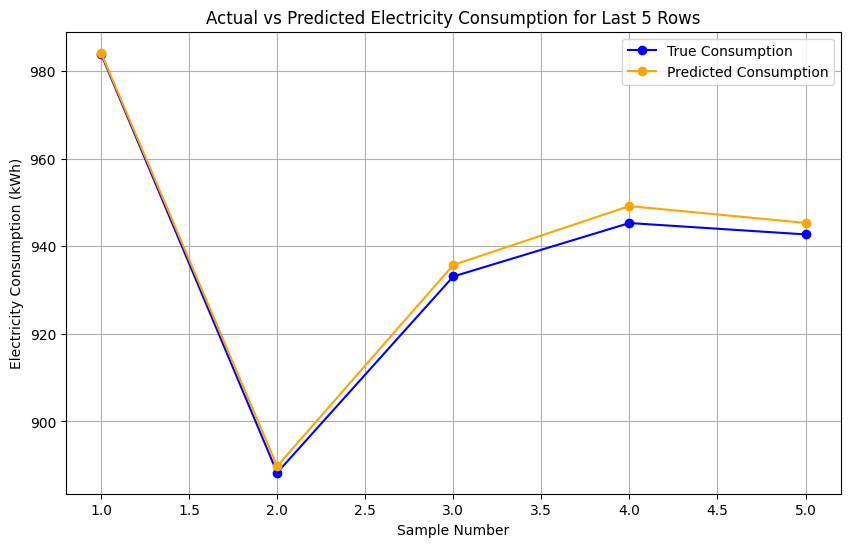

In [8]:
import matplotlib.pyplot as plt

# Assuming you have the necessary imports and data loaded

# Code to get y_true_last_5 and y_pred_last_5

# Create a line plot for the last 5 rows
plt.figure(figsize=(10, 6))
plt.plot(range(1, 6), y_true_last_5, label='True Consumption',
         marker='o', linestyle='-', color='blue')
plt.plot(range(1, 6), y_pred_last_5, label='Predicted Consumption',
         marker='o', linestyle='-', color='orange')

plt.title('Actual vs Predicted Electricity Consumption for Last 5 Rows')
plt.xlabel('Sample Number')
plt.ylabel('Electricity Consumption (kWh)')
plt.legend()
plt.grid(True)
plt.show()